In [131]:
import sys
sys.path.append('../')
from didgelab.calc.geo import Geo
from didgelab.util.didge_visualizer import vis_didge
import seaborn as sns
from didgelab.calc.conv import note_to_freq, freq_to_note_and_cent, note_name
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
import json
import matplotlib.pyplot as plt
from didgelab.calc.sim.sim import compute_impedance_iteratively, get_notes, compute_impedance, create_segments, get_log_simulation_frequencies, quick_analysis
from scipy.signal import argrelextrema


In [155]:
def smooth_didge(geo,resolution):

    # make spline
    x = [g[0] for g in geo.geo]
    y = [g[1] for g in geo.geo]
    xi = np.concatenate(([-10], x))
    yi = np.concatenate(([y[0]], y))
    bspl = make_interp_spline(xi, yi, k=2)

    x_spline = np.concatenate((x, np.arange(x[0], x[-1], resolution)))
    x_spline = np.arange(x[0], x[-1], resolution)
    x_spline = np.array(x_spline)
    y_spline = bspl(x_spline)
    
    # compute difference from spline to original shape
    orig_shape = np.array([geo.diameter_at_x(x) for x in x_spline])
    diff = y_spline - orig_shape

    # even out large deviations from the original shape
    i=diff<0
    diff[i] = -1*np.sqrt(diff[i]*-1)
    i=diff>0
    diff[i] = np.sqrt(diff[i])
    y_spline = orig_shape + diff

    # assure that the didge is never narrower than half the mouthpiece diameter
    y_spline = np.array([np.max((y_spline[0]/2, _y)) for _y in y_spline])

    x_spline = np.round(x_spline)
    y_spline = np.round(y_spline)

    
    geo = list(zip(x_spline, y_spline))
    return Geo(geo)

def create_geo():
    l=1000+np.random.random()*1000
    d1=32
    bellsize=60+np.random.random()*25

    x = np.random.sample(np.random.randint(10,15))
    x = np.sort(x)

    y = np.power(x, 2)
    y = np.power(x, 2)
    y /= y[-1]
    
    deltay = 0.3*2*(np.random.sample(len(y))-0.5)
    y += deltay
    
    y *= (bellsize-d1)
    y += d1

    # assure that the didge is never narrower than half the mouthpiece diameter
    y = np.array([np.max((y[0]/2, _y)) for _y in y])

    x *= l
    
    x = np.concatenate(([0], x, [l]))
    y = np.concatenate(([d1], y, [bellsize]))
    
    # delete duplicate coordinges
    delete = []
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            if x[i] == x[j]:
                delete.append(i)
    x = np.delete(x, delete)
    y = np.delete(y, delete)
    
    x = np.round(x)
    y = np.round(y)

    geo = []
    for (_x, _y) in zip(x,y):
        geo.append([_x, _y])

    geo = Geo(geo)
    return geo



In [173]:
freqs = get_log_simulation_frequencies(50, 120, 2)
tuned_notes = np.arange(-36, -23) # from A1-A2
tuned_frequencies = note_to_freq(tuned_notes)

def get_fundamental_freq(geo):
    segments = create_segments(geo)
    impedance = compute_impedance(segments, freqs)
    fundamental = np.argmax(impedance)
    return freqs[fundamental]

def get_deviation(geo, scaling, target):
    spline_scaled_x = [x[0]*scaling for x in geo.geo]
    geo_y = [x[1] for x in geo.geo]

    scaled_geo = Geo(list(zip(spline_scaled_x, geo_y)))
    fundamental = get_fundamental_freq(scaled_geo)

    #freqs = get_log_simulation_frequencies(50, 120, 2)
    #fundamental = spline_geo.get_cadsd().get_notes().freq.iloc[0]
    
    #print(spline_geo.get_cadsd().get_notes())
    return fundamental, np.abs(np.log2(fundamental)-target), scaled_geo

def find_scaling(geo, n_steps=10, interval=0.15, max_error=2):

    fundamental = get_fundamental_freq(geo)
    # print("fundamental", fundamental)
    argmin = np.argmin(np.abs(tuned_frequencies-fundamental))
    target_freq = tuned_frequencies[argmin]
    # print("target freq", target_freq)
    
    if np.abs(freq_to_note_and_cent(fundamental)[1]) < max_error:
        return fundamental, geo
    
    log_target_freq = np.log2(target_freq)
    
    assert fundamental>tuned_notes[0] or fundamental<tuned_notes[-1]
        
    deviation = np.abs(np.log2(fundamental)-target_freq)
    deviations = [deviation]
    scalings = [fundamental]
        
    i=0
    scaling=1

    f1, d1, ng = get_deviation(geo, scaling-interval, log_target_freq)

    if np.abs(freq_to_note_and_cent(f1)[1]) < max_error:
        return f1, ng
    
    f2, d2, ng = get_deviation(geo, scaling+interval, log_target_freq)
    if np.abs(freq_to_note_and_cent(f2)[1]) < max_error:
        return f2, ng
    
    f = (f1, f2)
    f1 = np.min(f)
    f2 = np.max(f)
    
    for i in range(n_steps):
        
        fnew, dnew, ng = get_deviation(geo, scaling, log_target_freq)
        if np.abs(freq_to_note_and_cent(fnew)[1]) < max_error:
            return fnew, ng

        interval /= 2
        if target_freq>fnew:
            f1=fnew
            d1=dnew
            scaling-=interval
        else:
            f2=fnew
            d2=fnew
            scaling+=interval

    f = (f1, f2)
    f1 = np.min(f)
    f2 = np.max(f)
            
    
    return fnew, ng

splined_geo = smooth_didge(geos[2],20)

fundamental, scaled_geo = find_scaling(splined_geo, interval=0.15, n_steps=10)
freq_to_note_and_cent(fundamental)

(-31, -0.9957715000780354)

(-28, -0.9957715000780354)
(-32, 1.0042284999215667)
(-26, 1.004228499921922)
(-32, -0.9957715000773248)
(-35, -0.9957715000773248)


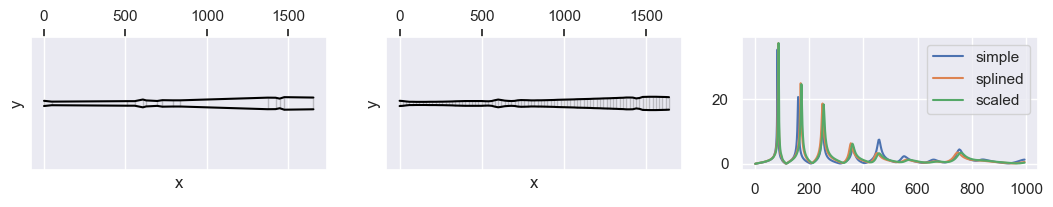

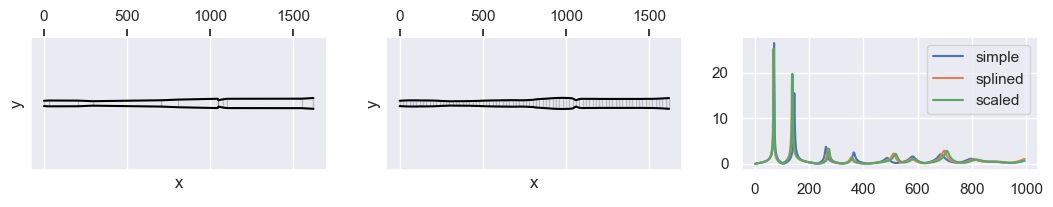

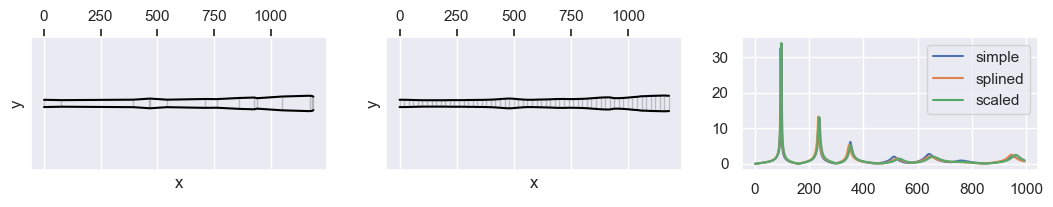

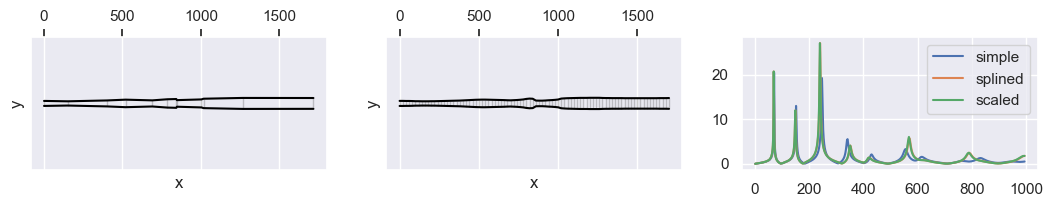

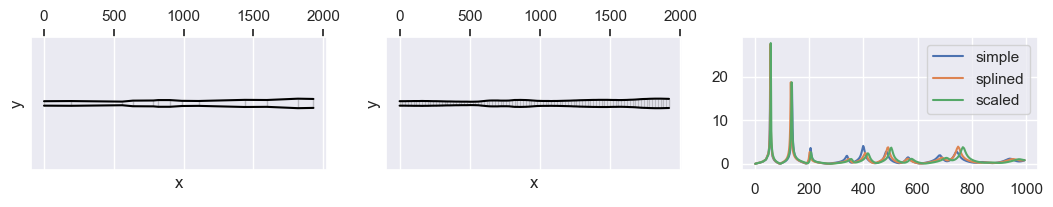

In [174]:
n=5
geos = []
splined_geos = []
scaled_geos = []
for i in range(n):
    plt.figure(figsize=(13,10))
    geo = create_geo()
    geos.append(geo)
    splined_geo = smooth_didge(geo,20)
    
    plt.subplot(n, 3, 3*i+1)
    vis_didge(geo)

    plt.subplot(n, 3, 3*i+2)
    vis_didge(splined_geo)
    
    plt.subplot(n, 3, 3*i+3)
    
    freq1, imp1 = compute_impedance_iteratively(geo, n_precision_peaks=3)
    plt.plot(freq1, imp1, label="simple")

    freq2, imp2 = compute_impedance_iteratively(splined_geo, n_precision_peaks=3)
    plt.plot(freq2, imp2, label="splined")
    
    fundamental, scaled_geo = find_scaling(splined_geo)
    scaled_geos.append(scaled_geo)
    freq3, imp3 = compute_impedance_iteratively(scaled_geo, n_precision_peaks=3)
    plt.plot(freq3, imp3, label="scaled")
    
    print(freq_to_note_and_cent(fundamental))

    plt.legend()


In [189]:
def extract_didge_info(geo):
    # get impedance
    freqs, impedances= compute_impedance_iteratively(geo, n_precision_peaks=10)
    
    features = {
        "length": geo.geo[-1][0],
        "mouthpiece_diameter": geo.geo[0][1],
        "bellsize": geo.geo[-1][1],
        "impedance_freqs": list(freqs),
        "impededances": list(impedances)
    }
    
    # get notes
    extrema = argrelextrema(impedances, np.greater)
    peak_freqs = freqs[extrema]
    note_and_cent = [freq_to_note_and_cent(f) for f in peak_freqs]

    peaks = {
        "note_name": [note_name(n[0]) for n in note_and_cent],
        "cent_diff": [float(n[1]) for n in note_and_cent],
        "note_nr": [int(n[0]) for n in note_and_cent],
        "freq": peak_freqs,
        "impedance": impedances[extrema],
    }
    
    print(peaks)
    peaks = pd.DataFrame(peaks)
    peaks["rel_imp"] = peaks.impedance / peaks.impedance.max()

    toots = peaks.query("rel_imp>0.2 and freq<500")

    fundamental = toots.query("freq>50 and freq<120").iloc[0]
    
    features["fundamental_note_name"] = fundamental["note_name"]
    features["fundamental_note_number"] = int(fundamental["note_nr"])
    features["fundamental_cent_diff"] = float(fundamental["note_nr"])
    features["playable_notes"] = list(toots.note_nr)
    features["peaks"] = {key: list(peaks[key]) for key in peaks.columns}
    
    return features

x=extract_didge_info(scaled_geos[-2])
for key, value in x.items():
    print(key)
    json.dumps(value)

{'note_name': ['C#1', 'D2', 'A#3', 'F3', 'G#3', 'C#4', 'G4'], 'cent_diff': [-1.1042519703075016, -23.81841093850241, -47.81841093850119, -9.818410938502353, -21.818410938502097, -42.222123072561146, -9.818410938501643], 'note_nr': [-32, -19, -11, -4, -1, 4, 10], 'freq': array([ 69.33987145, 148.86647224, 239.6095704 , 351.2144492 ,
       420.57182367, 568.05158982, 788.44978008]), 'impedance': array([20.67292191, 11.96104428, 27.02793848,  4.111464  ,  1.4156028 ,
        6.02795858,  2.4909133 ])}
length
mouthpiece_diameter
bellsize
impedance_freqs
impededances
fundamental_note_name
fundamental_note_number
fundamental_cent_diff
playable_notes
peaks


In [151]:
freqs = get_log_simulation_frequencies(50, 120, 2)
tuned_notes = np.arange(-36, -23) # from A1-A2
tuned_frequencies = note_to_freq(tuned_notes)

def get_fundamental_freq(geo):
    segments = create_segments(geo)
    impedance = compute_impedance(segments, freqs)
    fundamental = np.argmax(impedance)
    return freqs[fundamental]

def get_deviation(geo, scaling, target):
    spline_scaled_x = [x[0]*scaling for x in geo.geo]
    geo_y = [x[1] for x in geo.geo]

    scaled_geo = Geo(list(zip(spline_scaled_x, geo_y)))
    fundamental = get_fundamental_freq(scaled_geo)

    #freqs = get_log_simulation_frequencies(50, 120, 2)
    #fundamental = spline_geo.get_cadsd().get_notes().freq.iloc[0]
    
    #print(spline_geo.get_cadsd().get_notes())
    return fundamental, np.abs(np.log2(fundamental)-target), scaled_geo

def find_scaling(geo, n_steps=10, interval=0.05, max_error=2):

    fundamental = get_fundamental_freq(geo)
    argmin = np.argmin(np.abs(tuned_frequencies-fundamental))
    target_freq = tuned_frequencies[argmin]
    #print("target freq", target_freq)
    
    if np.abs(freq_to_note_and_cent(fundamental)[1]) < max_error:
        return fundamental, geo
    
    log_target_freq = np.log2(target_freq)
    
    assert fundamental>tuned_notes[0] or fundamental<tuned_notes[-1]
        
    deviation = np.abs(np.log2(fundamental)-target_freq)
    deviations = [deviation]
    scalings = [fundamental]
        
    i=0
    scaling=1

    f1, d1, ng = get_deviation(geo, scaling-interval, log_target_freq)

    if np.abs(freq_to_note_and_cent(f1)[1]) < max_error:
        return f1, ng
    
    f2, d2, ng = get_deviation(geo, scaling+interval, log_target_freq)
    if np.abs(freq_to_note_and_cent(f2)[1]) < max_error:
        return f2, ng
    
    f = (f1, f2)
    f1 = np.min(f)
    f2 = np.max(f)
    
    for i in range(n_steps):
        
        fnew, dnew, ng = get_deviation(geo, scaling, log_target_freq)
        if np.abs(freq_to_note_and_cent(fnew)[1]) < max_error:
            return fnew, ng

        interval /= 2
        if target_freq>fnew:
            f1=fnew
            d1=dnew
            scaling-=interval
        else:
            f2=fnew
            d2=fnew
            scaling+=interval

    f = (f1, f2)
    f1 = np.min(f)
    f2 = np.max(f)
            
    
    return fnew, ng


fundamental, scaled_geo = find_scaling(geos[2], interval=0.1, n_steps=10)



In [134]:
freq_to_note_and_cent(77.78174593052023)

(-30, 0.0)

In [152]:
quick_analysis(scaled_geo)["notes"]

,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,D#1,-1.368344,-30,77.843248,28.237495,1.000000
1,E2,-5.368344,-17,165.325639,4.218753,0.149403
2,D#3,18.631656,-6,307.796568,2.769688,0.098085
3,G3,4.631656,-2,390.948113,2.664961,0.094377
4,B4,22.631656,2,487.469001,9.063870,0.320987
5,D#4,25.631656,6,613.109097,3.859390,0.136676
6,F4,-20.368344,8,706.722485,4.472228,0.158379
7,G#4,15.631656,11,823.143415,1.046293,0.037053
8,B5,27.631656,14,972.126332,0.256342,0.009078


In [90]:
tuned_notes = np.arange(-36, -23) # from A1-A2
tuned_frequencies = note_to_freq(note)


-36 55.0 A1
-35 58.27047018976124 A#1
-34 61.7354126570155 B1
-33 65.40639132514966 C1
-32 69.29565774421802 C#1
-31 73.41619197935188 D1
-30 77.78174593052023 D#1
-29 82.4068892282175 E1
-28 87.30705785825097 F1
-27 92.4986056779086 F#1
-26 97.99885899543733 G1
-25 103.82617439498628 G#1
-24 110.0 A2


In [104]:
target_freq=100

target_cent = freq_to_note_and_cent(target_freq)[-1]
target_cent

-34.99577150007731